<a href="https://colab.research.google.com/github/HeesangJin/ml_study/blob/main/style_transfer_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!nvidia-smi

Sat Jul 16 13:15:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

VGG-19

training안하고 ImageNet으로 pretrained 된거 그대로 사용함
(trasfer learning)

In [4]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        #style_layers = ['r11','r21','r31','r41', 'r51'] 
        #content_layers = ['r42']
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [5]:
class GramMatrix(nn.Module): # gram matrix는 이미지 데이터 d = chw 를 d x d.t 한거 -> 이미지의 각 픽셀간의 관계 매트릭스..?
  def forward(self, x):
    b, c, h, w = x.size()
    F = x.view(c, h * w) # 이미지 1개씩 비교할거라서 b는 1임
    out = torch.mm(F, F.t()) # bcwh x wh* hwcb

    return out

class GramMSELoss(nn.Module):
  def forward(self, x, y):
    out = nn.MSELoss()(GramMatrix()(x), y) # y랑 x의 gram matrix와의 MESLoss를 구함
    # 함수 call이 이상한건 nn.MSELoss랑 GramMatrix Class를 처음에 instance만드는 것 때문임

    return out

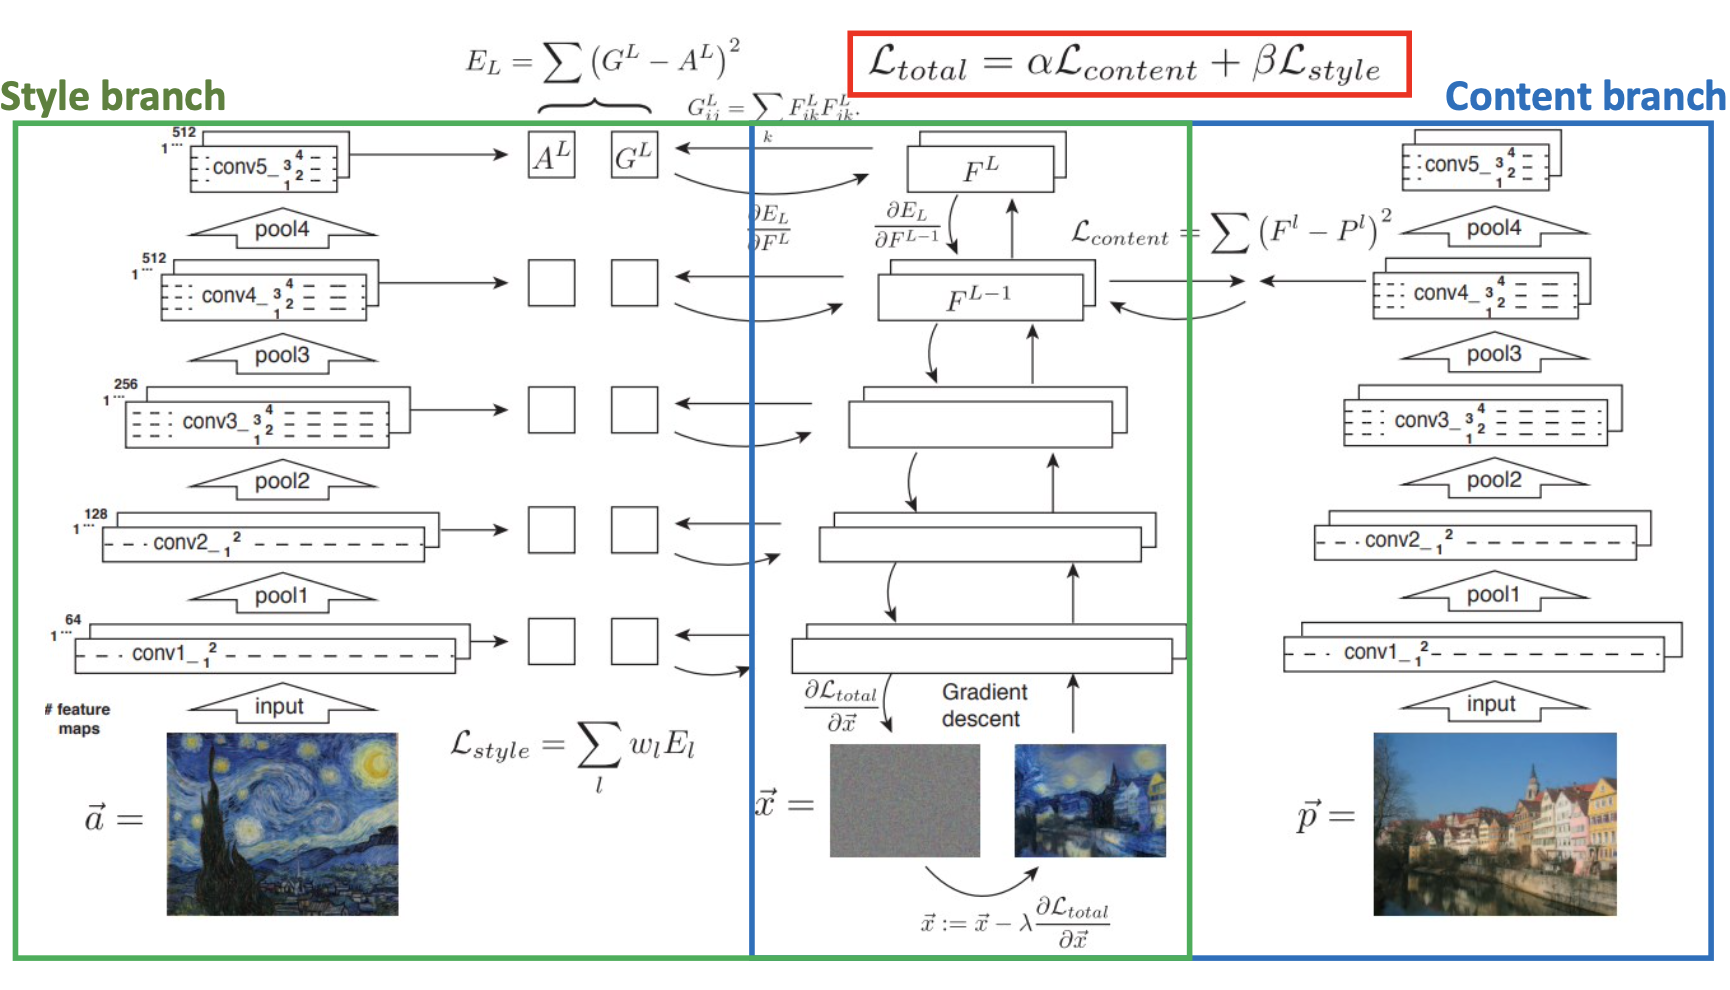

1. img_names: style image로 사용할 이미지, conten image로 사용할 이미지
2. style_layer: VGG net에서 어떤 layer의 feature와 style loss를 비교할지 정하는 변수
3. conten_layers: VGG net에서 어떤 layter의 feature와 content loss를 비교할지 정하는 변수
4. style_weights: style_layers 변수에서 정한 layer에서의 weight -> 어떤 layer에 가중치를 줄 것인지
5. content_weights: content_layers 변수에서 정한 layer에서의 weight
6. lr
7. max_iter: 몇번 반복할지 iteration -> 너무 커도 오히려 성능 안 좋을 수도 있음
8. show_iter: 이미 출력 iteration

In [6]:
img_size = 512
lr = 10
max_iter = 500
show_iter = 100

style_layers = ['r11', 'r21', 'r31', 'r41', 'r51']
content_layers = ['r42']

style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
content_weights = [1e0]

Dataloader

In [7]:
# image proprocessing
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul(255)), # normalize하고 다시 255를 곱함. 대체 왜?
                           # 원래 값보다 normalize하고 255 곱한게 의미가 더 있는 건가??
                           ]) # imagenet BGR의 평균값값 std dev
# proprocessing 한거 복구
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul(1./255)),
                             transforms.Normalize([-0.40760392, -0.45795686, -0.48501961], std=[1,1,1]),
                             transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
                             ])
# pillow: 이미지 처리 라이브러리
postpb = transforms.Compose([transforms.ToPILImage()])

def postp(tensor):
  t = postpa(tensor)
  t[t>1] = 1
  t[t<0] = 0
  img = postpb(t)
  return img

In [8]:
!ls /content/drive/MyDrive/study/ml_model

vgg_conv.pth


In [9]:
vgg = VGG() # vgg 정의한거 가져오고 weight는 imagenet으로 pretrained된거 그대로 다운로드 받음

# while 1:
#   try: 
#     vgg.load_state_dict(torch.load('./vgg_conv.pth'))
#     # local에 있는 pth 파일 일단 쓰긴 쓰는데, 이 부분 코드 pytorch에서 vgg모델 다운로드 받는거로 바꿔야 함
#     print("model loaded!")
#     break
#   except:
#     pass
    # 다운로드 링크 막힌듯. pytorch에서 vgg 모델 그대로 다운받아서 써야할 듯
    # print("Cannot load model, downloading new model!")
    # os.system('rm vgg_conv.pth')
    # os.system('wget -c --no-check-certificate https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth')
try: 
  vgg.load_state_dict(torch.load('/content/drive/MyDrive/study/ml_model/vgg_conv.pth'))
  print("success to load 'vgg_conv.pth'")
except:
  print("fail to load 'vgg_conv.pth'")

# training된거 그대로 쓸거고 더 학습 안 시킬거니까
# test 이미지로 학습 안되도록 vgg freeze 시킴
for param in vgg.parameters():
  param.requires_grad = False
if torch.cuda.is_available():
  vgg.cuda()

success to load 'vgg_conv.pth'


In [10]:
!ls

drive  sample_data  www.jpeg


In [11]:
style_image = './vangogh_starry_night.jpg'
if not os.path.isfile(style_image):
    os.system('wget https://raw.githubusercontent.com/leongatys/PytorchNeuralStyleTransfer/master/Images/vangogh_starry_night.jpg')
    print(f'{style_image} download completed.')

# content_image = './Tuebingen_Neckarfront.jpg'
# if not os.path.isfile(content_image):
#     os.system('wget https://raw.githubusercontent.com/leongatys/PytorchNeuralStyleTransfer/master/Images/Tuebingen_Neckarfront.jpg')
#     print(f'{content_image} download completed.')

content_image = './www.jpeg'
# if not os.path.isfile(content_image):
#     os.system('wget -O stranger.jpg https://www.co.kr')
#     print(f'{content_image} download completed.')

img_names = [style_image, content_image]

imgs = [Image.open(name) for i,name in enumerate(img_names)]
print('Image loaded!!')

./vangogh_starry_night.jpg download completed.
Image loaded!!


In [12]:
imgs_torch = [prep(img) for img in imgs]
imgs_torch = [img.unsqueeze(0).to(device) for img in imgs_torch]
style_image, content_image = imgs_torch
print(style_image.shape, content_image.shape)
opt_img = content_image.data.clone()

torch.Size([1, 3, 512, 646]) torch.Size([1, 3, 512, 796])


In [13]:
opt_img.requires_grad = True

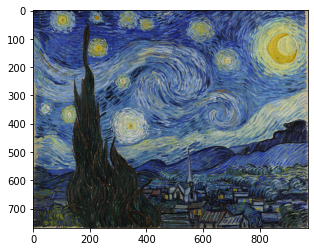

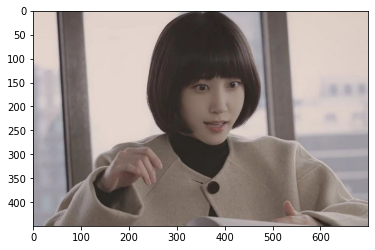

In [14]:
from pylab import *

for img in imgs:
  imshow(img)
  show()

Define Loss
비교 기준이 되는 style feature와 content feature의 값을 구하고 loss를 구함

In [15]:
# define layers, loss function, weights and compute optimization targets
loss_layers = style_layers + content_layers # vgg에서 어떤 CNN의 loss인를 사용할 것인지 기록
style_loss = [GramMSELoss()] * len(style_layers) # style loss 함수 정의 -> Style feature는 GramMSELoss 사용
content_loss = [nn.MSELoss()] * len(content_layers)
loss_fns = style_loss + content_loss
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns] # loss 함수 정의하고 gpu에 올림

weights = style_weights + content_weights # 각 레이어의 weight 저장 (0.2 *5, 1)

style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
# vgg에서 style_layers에 해당하는 5개 weights들 빼내고, 얘네의 Gram matrix 계산함
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
# vgg에서 content_layer에 해당하는 1개 weights를 빼냄. detach는 그냥 tensor 복사 (required_grad는 False로 바뀜)
targets = style_targets + content_targets

In [16]:
del sum

Iteration: 001, loss: 1.0680996800820675e+18


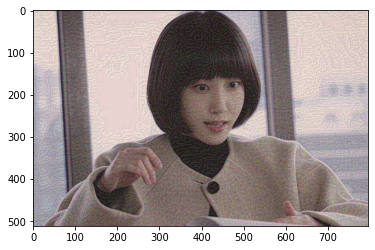

Iteration: 101, loss: 2567916385992704.0


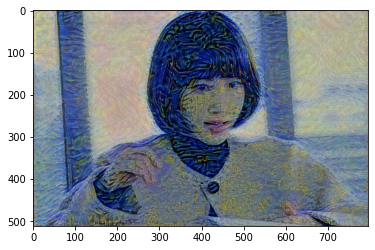

Iteration: 201, loss: 1112249829687296.0


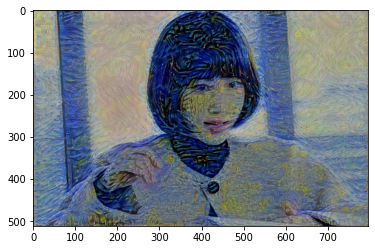

Iteration: 301, loss: 430428066414592.0


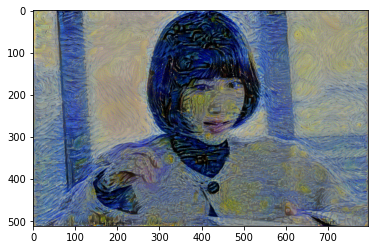

Iteration: 401, loss: 1007095340072960.0


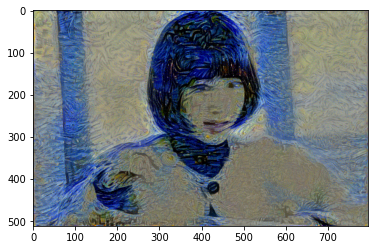

In [17]:
# model을 optimize하는게 아니라 opt_image를 optimize한다
# 아마 Objective image 인거 같고, 원래는 랜덤값으로 시작해서 optimize해야하지만, 
# 여기서는 그냥 원본이미지로 시작해서 함
optimizer = optim.Adam([opt_img], lr) # opt_img는 content 이미지

for n_iter in range(max_iter):
  out = vgg(opt_img, loss_layers)
  optimizer.zero_grad()
  layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
  # Style의 Gram matrix, Content의 중간 weight를 빼내고 비율값대로 곱해서 전체 loss를 구함
  loss = sum(layer_losses)
  loss.backward() # vgg는 freeze했는데 얘는 무슨 grad를 계산하는거지? opt_img의 grad??
  # vgg는 3개를 쓰는건가??? 뭔지를 모르겠네

  optimizer.step()

  if n_iter % show_iter == 0:
    print("Iteration: {:03d}, loss: {}".format(n_iter+1, loss.item()))
    out_img = postp(opt_img.data[0].cpu().squeeze())
    imshow(out_img)
    show()

Final result!


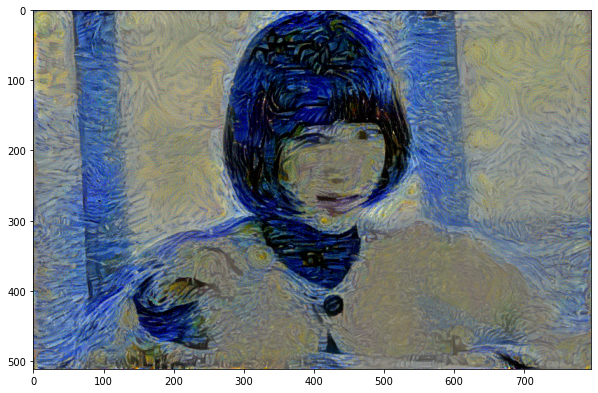

In [18]:
print("Final result!")
out_img = postp(opt_img.data[0].cpu().squeeze())
gcf().set_size_inches(10,10)
imshow(out_img)
show()

out_img.save('./style_transfer_reulst.png')